### M\oller for simplified model

In [1]:
import sys, os
sys.path.insert(0, 'core/')
import numpy as np
from matplotlib import pyplot as plt
from wave_pack import convolution, convolution2, delay
from wave_pack import inverse_pulse as pulse
from wave_pack import efficiency

#methods and procedures for creating various chains

class atomic_state(object):
    def __init__(self, noa: int, zpos, campl):
        if (len(zpos) != noa) or (len(campl) != noa):
            raise TypeError("Wrong Atomic State")
        self.noa = noa
        self.zpos = np.asarray(zpos, dtype = np.float64)
        if not np.vdot(campl, campl) == 0:
            self.campl = campl / np.vdot(campl, campl)
        else:
            self.campl = campl
        
#Creating a simple chain of noa atoms with period d
def create_chain(noa: int, d, random=False) -> object:
    zpos = d * np.arange(noa)
    if random:
        zpos = noa*d*np.sort(np.random.rand(noa))
    campl = np.ones_like(zpos, dtype=np.complex)
    return atomic_state(noa, zpos, campl)

#Creating an excited chain that decays mostly into waveguide
def create_excited_chain(noa: int, d) -> object:
    chain = create_chain(noa, d)
    for i in range(noa):
        chain.campl[i] *= np.exp(-2j*np.pi*chain.zpos[i])
    return chain

#Creating an chain that has no excitation    
def create_mirror_like_chain(noa: int, d, random=False) -> object:
    chain = create_chain(noa, d, random)
    chain.campl = np.zeros_like(chain.campl, dtype=np.complex)
    return chain
    
    
#Merging different chains
def merge_atomic_states(astate: object, bstate: object, distance, to_end = True) -> object:
    n1, n2 = astate.noa, bstate.noa
    add_dist = 0
    if to_end:
        add_dist = astate.zpos[-1]
    zpos = np.concatenate((astate.zpos, bstate.zpos + distance + add_dist), axis=None)    
    campl = np.concatenate((astate.campl, np.exp(2j*(distance+add_dist)*np.pi)*bstate.campl), axis=None)
    return atomic_state(n1+n2, zpos, campl)



#Scaling parameters

dp = 1/2
g = 1.
physical = {
'gwg': 1.05,
'alpha': 1.5 * 1e-7 # lambda * gamma / vg
    }


neff = 10000
estnoa = {
'gwg': 1. + (neff+1)*0.005,
'alpha': 1.5 * 1e-7 # lambda * gamma / vg
    }
    
def get_resolventa(state: object, omega, gwg, alpha):
    res_inv = np.eye(state.noa)*(omega + 0.5j*gwg)  #0.25j * (np.ones((noa,noa)))
    ddr2 = state.campl
    for i in range(state.noa):
        for j in range(state.noa):
            if i==j:
                continue
            res_inv[i,j] = +1j*(gwg - 1.) * np.exp(1j*(2*np.pi + alpha*omega)*abs(state.zpos[i] - state.zpos[j]))
    
    return np.linalg.solve(res_inv, ddr2)

def get_resmatrix(state: object, omega, gwg, alpha):
    res_inv = np.eye(state.noa)*(omega + 0.5j*gwg)  #0.25j * (np.ones((noa,noa)))
    ddr2 = state.campl
    for i in range(state.noa):
        for j in range(state.noa):
            if i==j:
                continue
            res_inv[i,j] = +1j*(gwg - 1.) * np.exp(1j*(2*np.pi + alpha*omega)*abs(state.zpos[i] - state.zpos[j]))
    
    return res_inv


def get_resmatrix2(state: object, omega, gwg, alpha):
    res_inv = np.eye(state.noa)*(omega + 0.5j*gwg)  #0.25j * (np.ones((noa,noa)))
    for i in range(state.noa):
        for j in range(state.noa):
            if i==j:
                continue
            res_inv[i,j] = +1j*(gwg - 1.) * np.exp(1j*(2*np.pi)*abs(state.zpos[i] - state.zpos[j]))
    
    return res_inv

def normplot(x,y,*args,**kwargs):
    plt.plot(x, y/y.max(), *args, **kwargs)
    
def get_psit(psi0: object, time, nof, f_max):
    
    freq = np.linspace(-f_max, f_max, nof)
    Decay = np.zeros((psi0.noa, nof), dtype=np.complex)
    for i,om in enumerate(freq):
        Decay[:, i] = get_resolventa(psi0, om, **estnoa)
        
    DecayTemp = np.zeros_like(Decay)
    
    for i in range(psi0.noa):
        t, DecayTemp[i, :] = convolution(freq, Decay[i, :], np.ones_like(freq))
    
    return t, DecayTemp

def get_psit2(psi0: object, time, nof, f_max):
    
    freq = np.linspace(-f_max, f_max, nof)
    Decay = np.zeros((psi0.noa, nof), dtype=np.complex)
    for i,om in enumerate(freq):
        Decay[:, i] = get_resolventa(psi0, om, **physical)
        
    DecayTemp = np.zeros((psi0.noa, len(time)), dtype=np.complex)
    
    for i in range(psi0.noa):
        DecayTemp[i, :] = convolution2(time, freq, Decay[i, :], np.ones_like(freq))
    
    return time, DecayTemp

def get_metrics(setup: object, time2, nof, f_max):
    t, setup_td = get_psit2(setup, time2, nof, f_max)
    setup_square = np.real(np.dot(np.conj(np.transpose(setup_td)), setup_td).diagonal())
    setup_init = abs(np.dot(np.conj(np.transpose(setup_td)), setup.campl))**2
    
    return setup_square, setup_init
    

In [4]:
nof = 12000
f_max = 500
#eps ~ 2f_max / nof
noa = 100


#100* bloch-like state

bloch100 = create_excited_chain(100, dp)

#100*-100:

dist = 2/4 #* 1e5
mirror100 = merge_atomic_states(bloch100, create_mirror_like_chain(noa, dp, random=False), dist)

#100-100*-100
resonator100 = merge_atomic_states(create_mirror_like_chain(noa, dp, random=False), mirror100, dist)

#100*-100*
#bloch100.campl = -1*bloch100.campl
#dephased100 = merge_atomic_states(bloch100, create_excited_chain(noa, dp), 1/12, False)

#t, BlochDecayTemp = get_psit(bloch100, nof, f_max)
#t, MirrorDecayTemp = get_psit(mirror100, nof, f_max)
#t, ResonatorDecayTemp = get_psit(resonator100, nof, f_max)



#time2 = np.linspace(-1, 8, 500)
#t, BlochDecayTemp = get_psit2(bloch100, time2, nof, f_max)
#t, MirrorDecayTemp = get_psit2(mirror100, time2, nof, f_max)
#t, ResonatorDecayTemp = get_psit2(resonator100, time2, nof, f_max)
#t, DephasedDecayTemp = get_psit2(dephased100, time2, nof, f_max)

In [55]:
BlochDecayTemp2 = np.real(np.dot(np.conj(np.transpose(BlochDecayTemp)), BlochDecayTemp).diagonal())

MirrorDecayTemp2 = np.real(np.dot(np.conj(np.transpose(MirrorDecayTemp)), MirrorDecayTemp).diagonal())
MirrorDecayTempIn = abs(np.dot(np.conj(np.transpose(MirrorDecayTemp)), mirror100.campl))**2

ResonatorDecayTemp2 = np.real(np.dot(np.conj(np.transpose(ResonatorDecayTemp)), ResonatorDecayTemp).diagonal())
ResonatorDecayTempIn = abs(np.dot(np.conj(np.transpose(ResonatorDecayTemp)), resonator100.campl))**2

#DephasedDecayTemp2 = np.real(np.dot(np.conj(np.transpose(DephasedDecayTemp)), DephasedDecayTemp).diagonal())

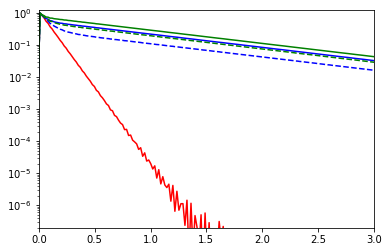

In [56]:
#plt.plot(t, sidemDecay1/sidemDecay1.max())
normplot(t, BlochDecayTemp2, 'r-')
#plt.plot(t, sidemDecay3/sidemDecay3.max())
normplot(t, MirrorDecayTemp2, 'b-')
#plt.plot(t, sidemDecay5/sidemDecay5.max())
normplot(t, MirrorDecayTempIn, 'b--')
#plt.plot(t, sidemDecay3/sidemDecay3.max()/0.79)
normplot(t, ResonatorDecayTemp2, 'g-')
#plt.plot(t, sidemDecay5/sidemDecay5.max())
normplot(t, ResonatorDecayTempIn, 'g--')
#normplot(t, DephasedDecayTemp2, 'k--')
plt.yscale('log')
#plt.xlim(0,10)
plt.xlim(0,3)
plt.ylim(0.0000002, 1.2)
plt.savefig('easy_decay80m.svg')
plt.show()

In [2]:
nof = 12000
f_max = 500
#eps ~ 2f_max / nof
noa = 100
noam = 50
time2 = np.linspace(-1, 8, 500)

#100* bloch-like state

bloch100 = create_excited_chain(noa, dp)
t, BlochDT = get_psit2(bloch100, time2, nof, f_max)
BlochDT2 = np.real(np.dot(np.conj(np.transpose(BlochDT)), BlochDT).diagonal())

#100*-100:

dist = 2/4 #* 1e5
mirror_hw = merge_atomic_states(bloch100, create_mirror_like_chain(noam, dp, random=False), dist)
t, Mirror_hwDT = get_psit2(mirror_hw, time2, nof, f_max)
Mirror_hwDT2 = np.real(np.dot(np.conj(np.transpose(Mirror_hwDT)), Mirror_hwDT).diagonal())
Mirror_hwDTin = abs(np.dot(np.conj(np.transpose(Mirror_hwDT)), mirror_hw.campl))**2


dist = 3/4 
mirror_tf = merge_atomic_states(bloch100, create_mirror_like_chain(noam, dp, random=False), dist)
t, Mirror_tfDT = get_psit2(mirror_tf, time2, nof, f_max)
Mirror_tfDT2 = np.real(np.dot(np.conj(np.transpose(Mirror_tfDT)), Mirror_tfDT).diagonal())
Mirror_tfDTin = abs(np.dot(np.conj(np.transpose(Mirror_tfDT)), mirror_tf.campl))**2


dist = 2/4 #* 1e5
rnd_hw = merge_atomic_states(bloch100, create_mirror_like_chain(noam, dp, random=True), dist)
t, Rnd_hwDT = get_psit2(rnd_hw, time2, nof, f_max)
Rnd_hwDT2 = np.real(np.dot(np.conj(np.transpose(Rnd_hwDT)), Rnd_hwDT).diagonal())
Rnd_hwDTin = abs(np.dot(np.conj(np.transpose(Rnd_hwDT)), rnd_hw.campl))**2

dist = 3/4 
rnd_tf = merge_atomic_states(bloch100, create_mirror_like_chain(noam, dp, random=True), dist)
t, Rnd_tfDT = get_psit2(rnd_tf, time2, nof, f_max)
Rnd_tfDT2 = np.real(np.dot(np.conj(np.transpose(Rnd_tfDT)), Rnd_tfDT).diagonal())
Rnd_tfDTin = abs(np.dot(np.conj(np.transpose(Rnd_tfDT)), rnd_tf.campl))**2



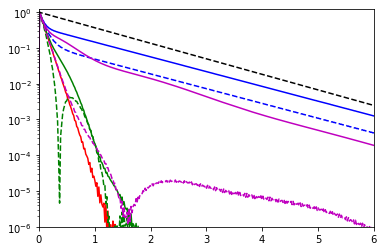

In [6]:
normplot(t, BlochDT2, 'r-')

normplot(t, Mirror_hwDT2, 'b-')
normplot(t, Mirror_hwDTin, 'b--')

normplot(t, Mirror_tfDT2, 'g-')
normplot(t, Mirror_tfDTin, 'g--')

normplot(t, Rnd_hwDT2, 'm-')
normplot(t, Rnd_hwDTin, 'm--')

#normplot(t, Rnd_tfDT2, 'c-')
#normplot(t, Rnd_tfDTin, 'c--')

plt.plot(t, np.exp(-t), 'k--')

plt.yscale('log')
plt.xlim(0,6)
plt.ylim(0.000001, 1.2)
plt.savefig('mirrors.svg')
plt.show()

In [4]:
nof = 12000
f_max = 500
#eps ~ 2f_max / nof
noa = 100
noam = 50
time2 = np.linspace(-1, 8, 500)

#100* bloch-like state

bloch100 = create_excited_chain(noa, dp)
t, BlochDT = get_psit2(bloch100, time2, nof, f_max)
BlochDT2 = np.real(np.dot(np.conj(np.transpose(BlochDT)), BlochDT).diagonal())

#mirror-exc.chain-miror:


dist = 2/4 #* 1e5
res_hw = merge_atomic_states(
    create_mirror_like_chain(noam, dp, random=False),
    merge_atomic_states(bloch100, 
                        create_mirror_like_chain(noam, dp, random=False), 
                        dist), dist)

t = time2
ReshwDT2, ReshwDTin = get_metrics(res_hw, time2, nof, f_max)


dist = 3/4 
res_hw = merge_atomic_states(
    create_mirror_like_chain(noam, dp, random=False),
    merge_atomic_states(bloch100, 
                        create_mirror_like_chain(noam, dp, random=False), 
                        dist), dist)


RestfDT2, RestfDTin = get_metrics(res_hw, time2, nof, f_max)



res_hw = merge_atomic_states(
    create_mirror_like_chain(noam, dp, random=True),
    merge_atomic_states(bloch100, 
                        create_mirror_like_chain(noam, dp, random=True), 
                        dist), dist)


ResRandDT2, ResRandDTin = get_metrics(res_hw, time2, nof, f_max)


dist = 1/4 
res_hw = merge_atomic_states(
    create_mirror_like_chain(noam, dp, random=False),
    merge_atomic_states(bloch100, 
                        create_mirror_like_chain(noam, dp, random=False), 
                        dist), dist)


ResofDT2, ResofDTin = get_metrics(res_hw, time2, nof, f_max)

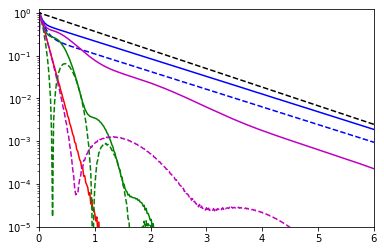

In [5]:
normplot(t, BlochDT2, 'r-')

normplot(t, ReshwDT2, 'b-')
normplot(t, ReshwDTin, 'b--')

normplot(t, RestfDT2, 'g-')
normplot(t, RestfDTin, 'g--')

normplot(t, ResRandDT2, 'm-')
normplot(t, ResRandDTin, 'm--')

plt.plot(t, np.exp(-t), 'k--')


plt.yscale('log')
plt.xlim(0,6)
plt.ylim(0.00001, 1.2)
plt.savefig('resonator.svg')
plt.show()

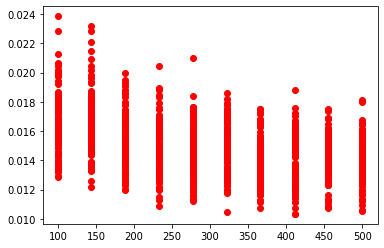

In [30]:
eig = np.linalg.eig

def funcfoo(n, dp):
    bloch = create_mirror_like_chain(n, dp, random=True)
    gamms, _ = eig(get_resmatrix(bloch, 0, 1.05, 0))
    return np.real(-1j * gamms).max()-0.5
#100*-100:

dist = 1/4 
#* 1e5
#mirror100 = merge_atomic_states(bloch100, create_mirror_like_chain(noa, dp, random=False), dist)

#100-100*-100
#resonator100 = merge_atomic_states(create_mirror_like_chain(noa, dp, random=False), mirror100, dist)


ns = np.linspace(100, 500, 10, dtype=np.int)
gs14 = np.asarray([funcfoo(x, 1) for x in ns])
gs12 = np.asarray([funcfoo(x, 1/2) for x in ns])
from matplotlib import pyplot as plt

#plt.plot(ns, gs14)
#plt.plot(ns, gs12)
nrep = 100
for i in range(nrep):
    plt.plot(ns, np.asarray([funcfoo(x, 1) for x in ns])/ns, 'ro')

plt.show()

In [ ]:
eig = np.linalg.eig

bloch = create_excited_chain(100, 1/2)
bloch2 = create_excited_chain(100, 1/4)
bloch3 = merge_atomic_states(merge_atomic_states(bloch2,bloch2,1/4),bloch2,1/4)

es, vs = eig(get_resmatrix(bloch, 0, 1.05, 0))
nk = np.real(-1j * es).argmax()
nk
ve1 = np.exp(2j*np.pi*bloch.zpos)
ve2 = np.exp(-2j*np.pi*bloch.zpos)

nmax = np.real(-1j * es).argmax()
nmin = np.real(-1j * es).argmin()


print(es[nmax])
ms = np.array([abs(np.dot(ve2, vs[:,k]))**2 for k in range(10)])
ves = np.real(-1j * es)
#print(abs(np.dot(ve2, vs[:,nmax]))**2)
plt.plot(ms/ms.max());
plt.plot((ves - ves.min())/(ves.max()-ves.min()))
#plt.plot(np.angle(vs[3]))
plt.show()

In [ ]:
nmax = np.real(-1j * es).argmax()
nmin = np.real(-1j * es).argmin()

plt.plot(np.abs(vs[:,0]) / np.pi)
#plt.plot(np.abs(vs[:,1]))
#plt.plot(abs(vs[:,nmin]))
plt.show()

In [ ]:
es[nmax]

In [ ]:
ve

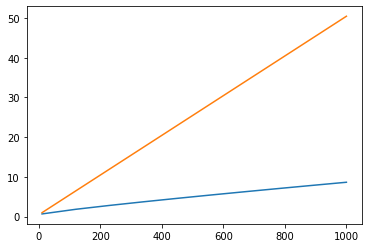

In [12]:
eig = np.linalg.eig
N1 = 100
d1 = 5+1/5

d2 = 1/5
N2 = 100#np.int(N1 * d1 / d2)

bloch = create_excited_chain(N1, d1)
bloch2 = create_excited_chain(N2, d2)
bloch3 = merge_atomic_states(merge_atomic_states(bloch2,bloch2,1/4),bloch2,1/4)

es, vs = eig(get_resmatrix(bloch, 0, 1.5, 0))
es2, vs2 = eig(get_resmatrix(bloch2, 0, 1.5, 0))

nk = np.real(-1j * es).argmax()
nk
ve1 = np.exp(2j*np.pi*bloch.zpos)
ve2 = np.exp(-2j*np.pi*bloch.zpos)

nmax = np.real(-1j * es).argmax()
nmax2 = np.real(-1j * es2).argmax()

nmin = np.real(-1j * es).argmin()


print(np.imag(es[nmax]-0.5j) * N2 / ( np.imag(es2[nmax2]-0.5j) * N1) )


0.9999999999999312


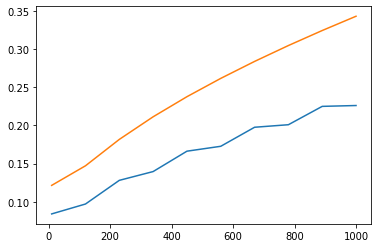

In [86]:
def foofel(n, dp):
    bloch = create_excited_chain(n, dp)
    e, _ = eig( get_resmatrix(bloch, 0, 1.05, 0))
    
    return np.imag(e).max() / n * (n* dp)**(2/3)


ns = np.linspace(10, 1000, 10, dtype=np.int)
gs14 = np.asarray([foofel(x, 1/4) for x in ns])
gs12 = np.asarray([foofel(x, 1/8) for x in ns])
plt.plot(ns, gs12)
plt.plot(ns, gs14)
plt.show()

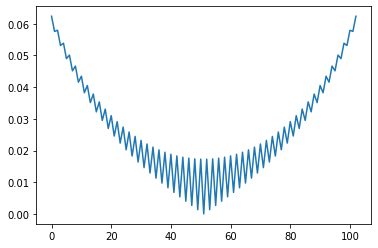

In [30]:
nmax = np.real(-1j * es).argmax()
nmin = np.real(-1j * es).argmin()

plt.plot(np.abs(vs[:,0]) / np.pi)
#plt.plot(np.abs(vs[:,1]))
#plt.plot(abs(vs[:,nmin]))
plt.show()

In [27]:
es[nmax]

(8.104628079763643e-15+1.7773503386033798j)

In [152]:
ve

[(0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 -0.1j,
 (-0.1+0j),
 0.1j,
 (0.1+0j),
 (4.408109496293883e-16-0.1j),
 (-0.1-9